# All imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import CRF
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# EDA

In [2]:
df = pd.read_csv('ner_dataset.csv',encoding='latin1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [4]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
df['Sentence #'].fillna(method='ffill',inplace=True)

In [6]:
print('Number of words: {n_word}, number of tags: {n_tags}'.format(n_word=df['Word'].nunique(), n_tags=df['Tag'].nunique()))

Number of words: 35178, number of tags: 17


In [7]:
print('Number of sentences: {n_sent}'.format(n_sent=df['Sentence #'].nunique()))

Number of sentences: 47959


Sentences' length distirbution

<AxesSubplot:xlabel='Word'>

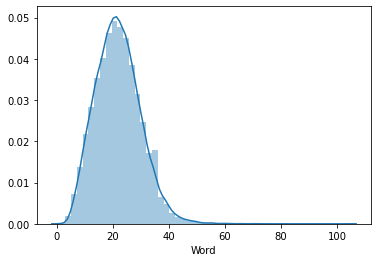

In [8]:
_tmp=pd.DataFrame(df.groupby('Sentence #')['Word'].count())
sns.distplot(a=_tmp['Word'])

Tags distribution

<AxesSubplot:ylabel='Tag'>

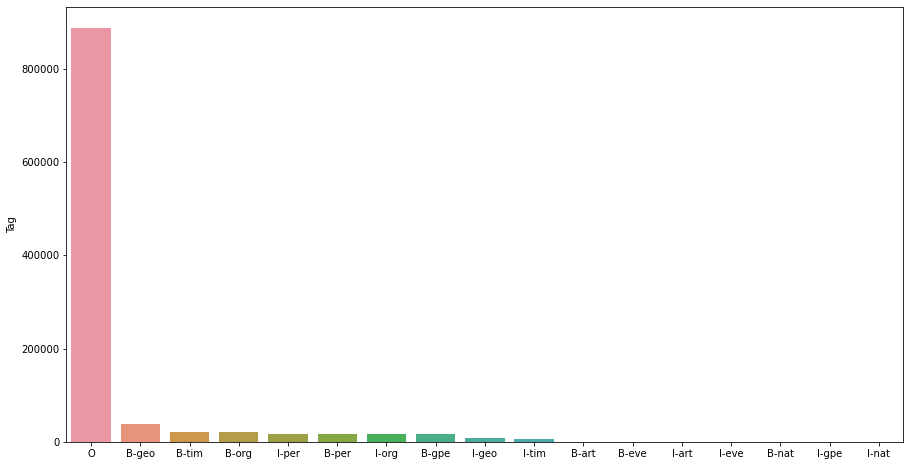

In [9]:
fig=plt.figure(figsize=(15,8))
_tmp = pd.DataFrame(df['Tag'].value_counts())
sns.barplot(x=_tmp.index,y=_tmp['Tag'])

Train/test split

In [10]:
train_df = df[df['Sentence #'].apply(lambda x: int(x.split()[1]) <= 35000)]
test_df = df[~df['Sentence #'].apply(lambda x: int(x.split()[1]) <= 35000)]

In [11]:
train_df.shape,test_df.shape

((765819, 4), (282756, 4))

# Baseline

In [12]:
class BaselineTagger():
    
    def fit(self, X, y):
        '''
        Expects a list of words as X and a list of tags as y.
        '''
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
    
    def predict(self, X, y=None):
        '''
        Predict the the tag from memory. If word is unknown, predict 'O'.
        '''
        return [self.memory.get(x, 'O') for x in X]

In [13]:
baseline_tagger = BaselineTagger()
baseline_tagger.fit(train_df['Word'], train_df['Tag'])
predictions = baseline_tagger.predict(test_df['Word'])

In [14]:
report = classification_report(y_pred=predictions, y_true=test_df['Tag'])
print(report)

              precision    recall  f1-score   support

       B-art       0.14      0.05      0.08        93
       B-eve       0.58      0.23      0.33        64
       B-geo       0.79      0.85      0.82     10218
       B-gpe       0.95      0.95      0.95      4372
       B-nat       0.46      0.52      0.49        54
       B-org       0.67      0.49      0.57      5496
       B-per       0.78      0.65      0.71      4528
       B-tim       0.87      0.76      0.81      5504
       I-art       0.05      0.02      0.03        55
       I-eve       0.50      0.11      0.17        66
       I-geo       0.73      0.61      0.67      1964
       I-gpe       0.68      0.66      0.67        59
       I-nat       0.00      0.00      0.00        12
       I-org       0.70      0.54      0.61      4609
       I-per       0.74      0.66      0.70      4561
       I-tim       0.61      0.13      0.22      1727
           O       0.97      0.99      0.98    239374

    accuracy              

# CRF

In [15]:
def extract_sentences(df):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    return [s for s in grouped]

In [16]:
train_sentences = extract_sentences(train_df)
test_sentences = extract_sentences(test_df)

We have to map each word into feature space for CRF. For such purpose we use the infomation about word, its form, POS tag as well as the similar infomation about predecessor and descendant

In [20]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [26]:
X_train = [sent2features(s) for s in train_sentences]
y_train = [sent2labels(s) for s in train_sentences]
X_test = [sent2features(s) for s in test_sentences]
y_test = [sent2labels(s) for s in test_sentences]

It's probably worth noting that different words have different number of features, however, CRF_suite handles it

In [31]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [32]:
crf.fit(X_train, y_train)
predictions = crf.predict(X_test)

In [33]:
report = flat_classification_report(y_pred=predictions, y_true=y_test)
print(report)

C:\Users\Aleksandr_Kartavchen\Miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.20      0.08      0.11        93
       B-eve       0.51      0.34      0.41        64
       B-geo       0.86      0.90      0.88     10218
       B-gpe       0.97      0.96      0.96      4372
       B-nat       0.67      0.52      0.58        54
       B-org       0.79      0.73      0.76      5496
       B-per       0.83      0.81      0.82      4528
       B-tim       0.93      0.87      0.90      5504
       I-art       0.04      0.02      0.02        55
       I-eve       0.45      0.20      0.27        66
       I-geo       0.80      0.79      0.80      1964
       I-gpe       0.81      0.64      0.72        59
       I-nat       0.43      0.50      0.46        12
       I-org       0.83      0.79      0.81      4609
       I-per       0.83      0.91      0.87      4561
       I-tim       0.84      0.76      0.79      1727
           O       0.99      0.99      0.99    239374

    accuracy              

# NN

In [34]:
words = list(set(train_df["Word"].values))
words.append('UNK')
words.append("ENDPAD")

In [35]:
n_words = len(words); 
n_words

30499

In [36]:
tags = list(set(train_df["Tag"].values))

In [37]:
n_tags = len(tags)
n_tags

17

In [38]:
train_sentences = extract_sentences(train_df)
test_sentences = extract_sentences(test_df)

In [39]:
max_len = 50 # is chosen based on the results of EDA
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [40]:
X_train = [[word2idx.get(w[0],word2idx['UNK']) for w in s] for s in train_sentences]
X_test = [[word2idx.get(w[0],word2idx['UNK']) for w in s] for s in test_sentences]

In [41]:
# such way of padding corresponds to the padding with 'UNK' at the end
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=n_words - 1)
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words - 1)

In [42]:
y_train = [[tag2idx[w[2]] for w in s] for s in train_sentences]
y_test = [[tag2idx[w[2]] for w in s] for s in test_sentences]

In [43]:
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

In [44]:
# OHE for y_train
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

This architecture allows us to map one sequence on other sequence

In [59]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)  
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) 

In [60]:
model = Model(input, out)

In [61]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [62]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
985/985 [==============================] - 63s 64ms/step - loss: 0.1548 - accuracy: 0.9611 - val_loss: 0.0727 - val_accuracy: 0.9783
Epoch 2/5
985/985 [==============================] - 67s 68ms/step - loss: 0.0590 - accuracy: 0.9830 - val_loss: 0.0566 - val_accuracy: 0.9833
Epoch 3/5
985/985 [==============================] - 67s 68ms/step - loss: 0.0482 - accuracy: 0.9860 - val_loss: 0.0529 - val_accuracy: 0.9846
Epoch 4/5
985/985 [==============================] - 68s 69ms/step - loss: 0.0432 - accuracy: 0.9874 - val_loss: 0.0509 - val_accuracy: 0.9850
Epoch 5/5
985/985 [==============================] - 69s 70ms/step - loss: 0.0397 - accuracy: 0.9884 - val_loss: 0.0511 - val_accuracy: 0.9849


In [63]:
predictions = model.predict(X_test)

In [64]:
predictions = np.argmax(predictions, axis=-1)

In [65]:
report = classification_report(y_pred=predictions.reshape(1,-1)[0], y_true=y_test.reshape(1,-1)[0], target_names=tag2idx.keys())
print(report)

              precision    recall  f1-score   support

       I-gpe       1.00      0.71      0.83        59
       B-nat       0.53      0.19      0.27        54
       B-per       0.76      0.82      0.79      4526
       I-tim       0.81      0.71      0.76      1722
       I-eve       1.00      0.02      0.03        66
       B-eve       0.88      0.22      0.35        64
       B-geo       0.86      0.89      0.88     10214
       I-nat       0.00      0.00      0.00        12
       B-tim       0.92      0.86      0.89      5501
       I-art       0.00      0.00      0.00        55
       B-gpe       0.97      0.94      0.95      4366
           O       1.00      1.00      1.00    604597
       I-org       0.81      0.75      0.78      4606
       B-art       0.00      0.00      0.00        93
       I-per       0.80      0.93      0.86      4558
       I-geo       0.86      0.74      0.80      1964
       B-org       0.76      0.70      0.73      5493

    accuracy              

# HMM

It's partly refactored and rewritten version of code of the HMM library with implemented laplace smoothing and UNK tokens 

In [141]:
class hmm:

  def __init__(self, state_list, obser_list):

    self.N = len(state_list)
    self.M = len(obser_list)
    self.S = state_list
    self.O = obser_list

    tmp = [0.0]*self.N # Temporary array for states

    # Matrix for transition probabilities - - - - - - - - - - - - - - - - - - -
    #
    self.A = []
    for i in range(self.N):  # One line per state
      self.A.append(tmp[:])

    # Vector for initial state probabilities  - - - - - - - - - - - - - - - - -
    #
    self.pi = tmp[:]

    tmp = [0.0]*self.M # Temporary array for observations

    # Matrix for observation probabilities  - - - - - - - - - - - - - - - - - -
    #
    self.B = []
    for i in range(self.N):  # One line per state
      self.B.append(tmp[:])

    # Make dictionaries with indices of state and observation names - - - - - -
    #
    self.S_ind = {}
    for i in range(self.N):
      self.S_ind[self.S[i]] = i
    self.O_ind = {}
    for i in range(self.M):
      self.O_ind[self.O[i]] = i
    
    
  def train(self, train_data, smoothing=None):
    # Sum up probabilities from training data - - - - - - - - - - - - - - - - -
    #
    for train_rec in train_data:
      (init_state, init_obser) = train_rec[0]  # Get first tuple
      i = self.S_ind[init_state]
      self.pi[i] = self.pi[i] + 1.0
      prev_i = -1  # No previous index yet

      for pair in train_rec:  # For each pair in this training record
        (state,obser) = pair
        i = self.S_ind[state]
        j = self.O_ind[obser]
        self.B[i][j] = self.B[i][j] + 1.0
        if (prev_i > -1):  # If previous index defined:
          self.A[prev_i][i] = self.A[prev_i][i] + 1.0
        prev_i = i

    # Scale counts into probabilities - - - - - - - - - - - - - - - - - - - - -
    #

    # Scale initial probabilities
    #
    s = 0.0
    for i in range(self.N):
      s = s+self.pi[i]
    if (s != 0.0):
      for i in range(self.N):
        self.pi[i] = self.pi[i] / s

    # Scale transition probabilities
    #
    for i in range(self.N):  # For each state
      s  = 0.0
      for j in range(self.N):
        s = s+self.A[i][j]
      if (s != 0.0):
        for j in range(self.N):
          self.A[i][j] = self.A[i][j] / s

    # Scale observation probabilities
    #
    for i in range(self.N):  # For each state
      s  = float(self.M)
      for j in range(self.M):
        s = s+self.B[i][j]
      for j in range(self.M):
        self.B[i][j] = (self.B[i][j]+1.0) / s

    
  def viterbi(self, obser_seq):
    tmp = [0]*self.N

    obs_len = len(obser_seq)
    obs_ind = []
    for obs in obser_seq:
      obs_ind.append(self.O_ind.get(obs, self.O_ind['Unk']))

    delta = [tmp[:]]  # Compute initial state probabilities
    for i in range(self.N):
      delta[0][i] = self.pi[i] * self.B[i][obs_ind[0]]

    phi = [tmp[:]]

    for obs in obs_ind[1:]:  # For all observations except the inital one
      delta_t = tmp[:]
      phi_t = tmp[:]
      for j in range(self.N):   # Following formula 33 in Rabiner'89
        tdelta = tmp[:]
        tphimax = -1.0
        for i in range(self.N):
          tphi_tmp = delta[-1][i] * self.A[i][j]
          if (tphi_tmp > tphimax):
            tphimax = tphi_tmp
            phi_t[j] = i
          tdelta[i] = tphi_tmp * self.B[j][obs]
        delta_t[j] = max(tdelta)
      delta.append(delta_t)
      phi.append(phi_t)

    # Backtrack the path through the states  (Formula 34 in Rabiner'89)
    #
    tmax = -1.0
    for i in range(self.N):
      if (delta[-1][i] > tmax):
        tmax = delta[-1][i]
        state_seq = [i]  # Last state with maximum probability

    phi.reverse()  # Because we start from the end of the sequence
    for tphi in phi[:-1]:
      state_seq.append(tphi[state_seq[-1]])

    sequence = []

    for state in state_seq:
      sequence.append(self.S[state])

    sequence.reverse()  # Reverse into correct time direction
    state_seq.reverse()

    # Finally compute probability of this state and observation sequence
    #
    prev_ind = state_seq[0]
    seq_prob = self.pi[prev_ind]
    seq_prob *= self.B[prev_ind][self.O_ind.get(obser_seq[0], self.O_ind['Unk'])]

    for i in range(1,len(state_seq)):
      ind = state_seq[i]
      obs = self.O_ind.get(obser_seq[i], self.O_ind['Unk'])
      seq_prob *= self.A[prev_ind][ind]
      seq_prob *= self.B[ind][obs]
      prev_ind = ind

    return [sequence, seq_prob]

In [142]:
states = list(set(train_df["Tag"].values))
observ = list(set(train_df['Word'].values)) + ['Unk']

In [143]:
def extract_sentences_without_tags(df):
    agg_func = lambda s: [(t, w) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    return [s for s in grouped]

In [144]:
train_sentences = extract_sentences_without_tags(train_df)

In [147]:
test_hmm = hmm(states, observ)
test_hmm.train(train_sentences)

In [148]:
_tmp = test_df.groupby("Sentence #").apply(lambda x: x['Word'].values.tolist())
test_sentences = [s for s in _tmp]
_tmp = test_df.groupby("Sentence #").apply(lambda x: x['Tag'].values.tolist())
y_test = [y for y in _tmp]

In [149]:
predictions = []
for sent in test_sentences:
    predictions.append(test_hmm.viterbi(sent)[0])

In [150]:
report = flat_classification_report(y_pred=predictions, y_true=y_test)

In [151]:
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        93
       B-eve       0.00      0.00      0.00        64
       B-geo       0.83      0.87      0.85     10218
       B-gpe       0.88      0.92      0.90      4372
       B-nat       0.00      0.00      0.00        54
       B-org       0.79      0.60      0.69      5496
       B-per       0.77      0.68      0.72      4528
       B-tim       0.91      0.74      0.82      5504
       I-art       0.00      0.00      0.00        55
       I-eve       0.00      0.00      0.00        66
       I-geo       0.75      0.67      0.71      1964
       I-gpe       1.00      0.69      0.82        59
       I-nat       0.00      0.00      0.00        12
       I-org       0.72      0.75      0.74      4609
       I-per       0.73      0.92      0.82      4561
       I-tim       0.82      0.41      0.55      1727
           O       0.98      0.99      0.98    239374

    accuracy              